<div style="display: top; background-image:url('https://d1.awsstatic.com/SageMaker/SageMaker%20reInvent%202020/ImgHead_Mohave.3b1df33baa5f71b53237bfa6911fb3adc4902c0e.png');background-position: center ;background-repeat: no-repeat;background-size: 100%; padding-top:20px;">
<div style="color:#FFFFFF; text-align: top;padding-bottom: 25px; padding-left: 15px"><h1 style="font-weight: 900;">K Nearest Neighbors Model </h1>
</div>
</div>
<br>

In this notebook, we build and train a [__K Nearest Neighbors Classifier__](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __Outcome Type__ field of our Austin Animal dataset.

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Target balancing (upsampling)</a>
5. <a href="#5">Data processing with Transfomers</a>
6. <a href="#6">Train a classifier</a>
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Improvement ideas</a>

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a single __Austin_Animal_dataset.csv__ file. We also didn't consider animals with multiple entries to the facility to keep our dataset simple. If you want to see the original datasets and the merged data with multiple entries, they are available under `DATA/austin-animal` folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv and Austin_Animal_Center_Intakes_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Age upon Outcome Days__ - Age of pet at outcome (days)


In [1]:
# # Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [3]:
df = pd.read_csv("../../DATA/austin-animal/Austin_Animal_dataset.csv")

print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (95485, 13)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head()

Pet ID  Outcome Type Sex upon Outcome        Name  \
0  A794011           1.0    Neutered Male       Chunk   
1  A776359           1.0    Neutered Male       Gizmo   
2  A674754           0.0      Intact Male         NaN   
3  A689724           1.0    Neutered Male  *Donatello   
4  A680969           1.0    Neutered Male       *Zeus   

                        Found Location      Intake Type Intake Condition  \
0                          Austin (TX)  Owner Surrender           Normal   
1    7201 Levander Loop in Austin (TX)            Stray           Normal   
2        12034 Research in Austin (TX)            Stray          Nursing   
3     2300 Waterway Bnd in Austin (TX)            Stray           Normal   
4  4701 Staggerbrush Rd in Austin (TX)            Stray          Nursing   

  Pet Type Sex upon Intake                    Breed               Color  \
0      Cat   Neutered Male   Domestic Shorthair Mix   Brown Tabby/White   
1      Dog     Intact Male  Chihuahua Shorthair Mix         White/Brown   
2      Cat     Intact Male   Domestic Shorthair Mix        Orange Tabby   
3      Cat     Intact Male   Domestic Shorthair Mix               Black   
4      Cat     Intact Male   Domestic Shorthair Mix  White/Orange Tabby   

   Age upon Intake Days  Age upon Outcome Days  
0                   730                    730  
1                   365                    365  
2                     6                      6  
3                    60                     60  
4                     7                     60

In [5]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [6]:
# This prints basic statistics for numerical columns
df.describe()

Outcome Type  Age upon Intake Days  Age upon Outcome Days
count  95485.000000          95485.000000           95485.000000
mean       0.564005            703.436959             717.757313
std        0.495889           1052.252197            1055.023160
min        0.000000              0.000000               0.000000
25%        0.000000             30.000000              60.000000
50%        1.000000            365.000000             365.000000
75%        1.000000            730.000000             730.000000
max        1.000000           9125.000000            9125.000000

Let's separate model features and model target. 

In [7]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [8]:
model_features = df.columns.drop("Outcome Type")
model_target = "Outcome Type"

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')
Model target:  Outcome Type


We can explore the features set further, figuring out first what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features. 

In [9]:
numerical_features = df[model_features].select_dtypes(include=np.number).columns
print("Numerical columns:", numerical_features.tolist())

print("")

categorical_features = df[model_features].select_dtypes(include="object").columns
print("Categorical columns:", categorical_features.tolist())

Numerical columns: ['Age upon Intake Days', 'Age upon Outcome Days']

Categorical columns: ['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color']


#### Target distribution

Let's check our target distribution.

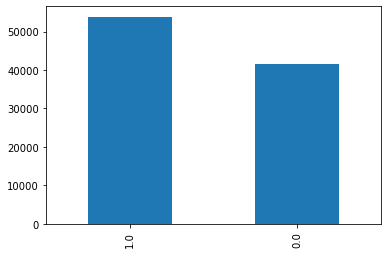

In [10]:
df[model_target].value_counts().plot.bar()
plt.show()

From the target plots we can identify whether or not we are dealing with imbalanced datasets - this means one result type is dominating the other one(s). 

Handling class imbalance is highly recommended, as the model performance can be greatly impacted. In particular the model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, and so it would be hard for the classifier to identify and match those patterns. 

We might want to downsample the dominant class or upsample the rare the class, to help with learning its patterns.

## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

We only consider the __numerical features__ to build the model for this first sample solution. 

Let's examine the numerical features.

Age upon Intake Days


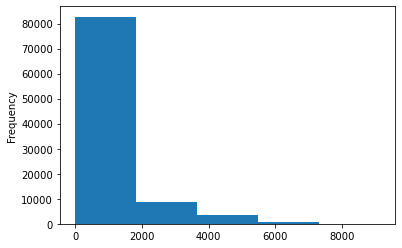

Age upon Outcome Days


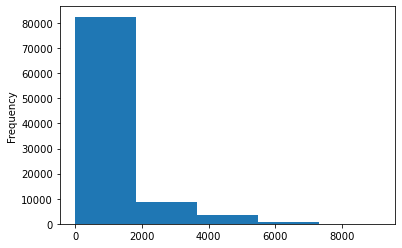

In [11]:
for c in numerical_features:
    print(c)
    df[c].plot.hist(bins=5)
    plt.show()

If for some histograms the values are heavily placed in the first bin, it is good to check for outliers, either checking the min-max values of those particular features and/or explore value ranges.

In [12]:
for c in numerical_features:
    print(c)
    print("min:", df[c].min(), "max:", df[c].max())
    print("\n")

Age upon Intake Days
min: 0 max: 9125


Age upon Outcome Days
min: 0 max: 9125




With `value_counts()` function, we can increase the number of histogram bins to 10 for more bins for a more refined view of the numerical features.

In [13]:
for c in numerical_features:
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    print("\n")

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Intake Days, dtype: int64


Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Outcome Days, dtype: int64




If any outliers are identified as very likely wrong values, dropping them could improve the numerical values histograms, and later overall model performance. While a good rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, other rules for removing 'outliers' should be considered as well. 

Let's check missing values for these numerical features.

In [14]:
print(df[numerical_features].isna().sum())

Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64


If any missing values, as a quick fix, we can apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

Also, more exploratory data analysis might reveal other important hidden atributes and/or relationships of the model features considered. 

## 4. <a name="4">Target balancing (upsampling)</a>
(<a href="#0">Go to top</a>)


#### Target balancing

In [15]:
print("Data set shape:", df.shape)

print("Class 0 samples in the data set:", sum(df[model_target] == 0))
print("Class 1 samples in the data set:", sum(df[model_target] == 1))

Data set shape: (95485, 13)
Class 0 samples in the data set: 41631
Class 1 samples in the data set: 53854


In [16]:
class_0_no = df[df[model_target] == 0]
class_1_no = df[df[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(
    n=len(class_1_no), replace=True, random_state=42
)

train_data = pd.concat([class_1_no, upsampled_class_0_no])
train_data = shuffle(train_data)

In [17]:
print("Data set shape:", train_data.shape)

print("Class 0 samples in the data set:", sum(train_data[model_target] == 0))
print("Class 1 samples in the data set:", sum(train_data[model_target] == 1))

Data set shape: (107708, 13)
Class 0 samples in the data set: 53854
Class 1 samples in the data set: 53854


## 5. <a name="5">Data processing with Transformers</a>
(<a href="#0">Go to top</a>)

We build a pipeline to impute the missing values with the mean using sklearn's SimpleImputer, scale the numerical features to have similar orders of magnitude by bringing them into the 0-1 range with sklearn's MinMaxScaler, and finally train an estimator [K Nearest Neighbor Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on the imputed and scaled dataset. 


In [18]:
# Initilizing transformers and model
imputer = SimpleImputer(strategy="most_frequent")
scaler = MinMaxScaler()
knn_model = KNeighborsClassifier(n_neighbors=3)

# Applying transformers
train_data[numerical_features] = imputer.fit_transform(train_data[numerical_features])
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

Reminder: We only want to use the numerical features for now!

In [19]:
# Seperating features from target
X = train_data[numerical_features]
y = train_data[model_target].tolist()

## 6. <a name="6">Train a classifier</a>
(<a href="#0">Go to top</a>)

We train our classifier with `.fit()` on our dataset. 

In [20]:
# Fit the classifier to the data
knn_model.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

## 7. <a name="7">Test the classifier</a>
(<a href="#0">Go to top</a>)

Let's make some predictions with the classifier. We use `.predict()` this time. Let's first see what the model predicts for the first 10 records of our dataset.

In [21]:
knn_model.predict(X[:10])

array([1., 1., 1., 1., 1., 0., 1., 0., 0., 0.])

In [22]:
accuracy_score(y, knn_model.predict(X))

0.6021651130835222

### 8. <a name="8">Ideas for improvement</a>
(<a href="#0">Go to top</a>)

In this dataset, the numerical columns are linked (__Age upon Intake Days__ and __Age upon Outcome Days__). Whenever this is the case, it would make sense to create a new feature that is the difference between the two original features. Generally, simple models with fewer features are preferred - simple models are easier to interpret and debug.

* Try to use the difference in age as feature

In this notebook, we showed up-sampling. However, as there are sufficient examples in the under-represente class downsampling would be a viable alternative.

* Try down-sampling instead of up-sampling